<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <title>Extraction de Trajectoires</title>
    <style>
        h1 {
            color: skyblue;
            font-size: 30px;
            font-weight: bold; /* Notez que c'est 'font-weight' et non 'font-style' pour le gras */
        }
        .red-text {
            color: red;
        }
        .green-text {
            color: DarkSeaGreen;
        }
    </style>
</head>
<body>
    <h1>Pre-test analyse des images</h1>
    <p>L'objectif de ce programme est simplement d'analyser la première image pour tester si les paramètres de traitement sont efficaces. Pour cela, on peut vérifier les tracés de particules repérés et des graphiques de mass et taille. Ces paramètres sont à copier par la suite dans le code de tracking.</p>
</body>
</html>


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import util
import trackpy as tp

<center><span style="color: skyblue; font-size: 30px; font-style: bold">Définition des paramètres d'études </span></center>

In [5]:
# Consolidated parameters
PARAMS = {
        # Préparation images
        'GaussianBlur': (5, 5), # (19, 19), #  (5, 5),
        'sigmaX': 10,
        'sigmaY': 10, 
        'threshold': 1, # 3, # 10  # 40,
        'percentile': 10, #10,
        'lenght_study': 50, # Découpage de la manip en nombre de frale pour favoriser l'étude (performence ordi)
        'smoothing_size': None,
        'invert': False,
        'preprocess': True, 
        'characterize': True,
        'filter_before': None,
        'filter_after': None,
        # Paramètres Manip
        'pixel_size': 0.637,  # 1.2773, # en um
        'frame_interval': 15, # temps entre chaque frame [s]
        'long_time': False,
        'max_frame': 340, # 340, #340 # Nombre de frame d'étude max.
        'min_frames': 150, #150, # Nombre de frame sur laquelle doit être suivie une cellule
        'topn': 500, # None, # Nombre de particules max à détecter

        # Détéction particules
        'diameter': 15,  # 15, # Diamètres évalué des particules
        'max_displacement': 30, # 35, # 25, # Déplacement maximal des cellules entre deux images (en pixel)
        'search_range': 30, #  30, #  20 # même chose
        'minmass': 500, #  Mass minimale mesurée des cellules
        'max_size': 30, # 25, # Taille maximum de la particule
        'separation': 20, # 9, # distance mimimanl pour séparé deux objets
        'noise_size': 3,  # 7, # 7, # taille des particules à exclure 
        'max_iterations': 15, # Nombre d'itérations max pour résoudre un sous-réseau (déterminer les trajectoires entre 2 cellules)
        'memory': 5, # Nombre de frame au dela de laquelle on oublie la cellule
        'engine': 'auto',

        # Format et chemins
        'remove_exts': ['.jpg', '.svg', 'hdf5', '.png'],   
        'data_dir': '/Users/souchaud/Desktop/A_Analyser/CytoOne_SorC_10x/',
        # 'data_dir': '/Volumes/Labo_Alex_Mac/A_analyser/CytoOne_HL5/',
        # 'data_dir': '/Users/souchaud/Desktop/A_Analyser/NonT_SorC/',
        # 'output_dir': '/Users/souchaud/Desktop/Analyses/CytoOne_HL5_longtime/'
        # 'data_dir': '/Volumes/Labo_Alex_Mac/A_analyser/CytoOne_HL5/',´
        'output_dir': '/Users/souchaud/Desktop/Analyses/CytoOne_SorC_10x_results_tracking/'
        # 'output_dir': '/Users/souchaud/Desktop/Analyses/NonT_SorC_longtime_New/'
        }

In [6]:
# # Charger l'image
# manip = '2024_03_26_ASMOT141_AX3_2024_P1_10x_CytoOne_HL5_2603-10h25-2603-14h30'
# manip = '2024_03_26_ASMOT140_AX3_2024_P1_10x_CytoOne_HL5_2603-10h25-2603-10h45'
# manip = '2024_03_26_ASMOT142_AX3_2024_P1_10x_CytoOne_HL5_2603-10h25-2703-09h35'
# manip = '2024_03_26_ASMOT143_AX3_2024_P1_10x_CytoOne_HL5_2603-17h00-2703-12h00'
# manip = '2024_03_26_ASMOT145_AX3_2024_P1_10x_CytoOne_HL5_2603-17h00-2703-17h25'
# manip = '2024_03_28_ASMOT147_AX3_2024_P1_10x_CytoOne_HL5_2603-17h00-2803-13h55'
# manip = '2024_04_30_ASMOT154_AX3_2024_P4_10x_CytoOne_HL5_2604-10h30_3004_09h15'
manip = '2024_10_14_ASMOT185_AX3_2024_P3_10x_CytoOne_SorC_1410-10h30_1410_11h20'
# image = cv2.imread('/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x/2024_03_06_ASMOT133_AX3_MAT_P3_10x_CytoOne_HL5_0403-15h-0603-09h10/mosaic/mosaic_total_0.tif', cv2.IMREAD_GRAYSCALE)
tiff_file = f'/Users/souchaud/Desktop/A_analyser/CytoOne_SorC_10x/{manip}/mosaic/mosaic_total_0.tif'
import imageio
image = np.array(imageio.imread(tiff_file))

/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_4561/3760716473.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = np.array(imageio.imread(tiff_file))


In [7]:
# Prétraitement
blurred = ndimage.median_filter(image, size=8)
blurred = cv2.GaussianBlur(blurred, PARAMS['GaussianBlur'], 0)
frame = blurred
# equalized = cv2.equalizeHist(blurred)
# frame = util.invert(blurred)

121


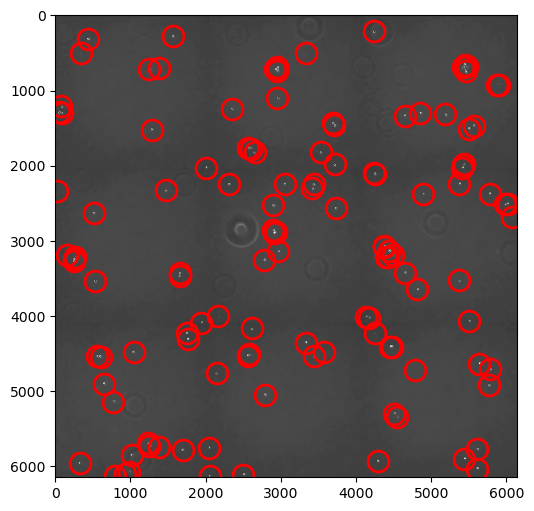

In [8]:
# # Create a CLAHE object (Arguments are optional)
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
# # Apply CLAHE
# frame = clahe.apply(frame)
for percentile in [5]: 
    f = tp.locate(frame,
                diameter=PARAMS['diameter'],
                minmass=PARAMS['minmass'],
                maxsize=PARAMS['max_size'],
                separation=PARAMS['separation'],
                noise_size=PARAMS['noise_size'],
                smoothing_size=PARAMS['smoothing_size'],
                threshold=PARAMS['threshold'], # 20,
                invert=PARAMS['invert'],
                percentile=PARAMS['percentile'],
                topn=PARAMS['topn'],
                preprocess=PARAMS['preprocess'],
                max_iterations=PARAMS['max_iterations'],
                filter_before=PARAMS['filter_before'],
                filter_after=PARAMS['filter_after'],
                characterize=PARAMS['characterize'],
                engine=PARAMS['engine'])
    print(len(f))

    fig, ax = plt.subplots(figsize=(12, 6))
    tp.annotate(f, frame, ax=ax)
    # display(fig)


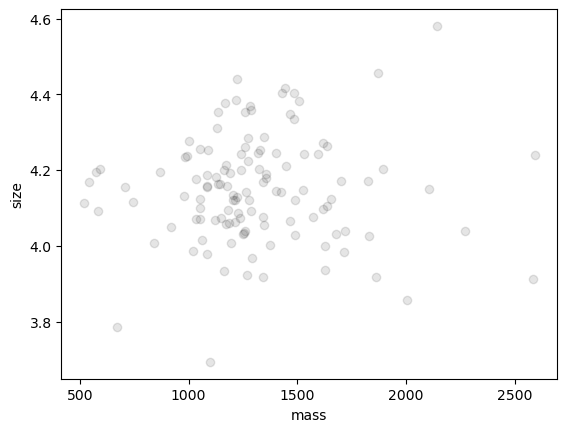

<Axes: xlabel='mass', ylabel='size'>

In [9]:
tp.mass_size(f)

In [10]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import ndimage

# def get_top_x_percent_luminous_pixels(image_path, percentile):
#     # Charger l'image en grayscale
#     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     ndimage.median_filter(image, size=5)

#     # Calculer le seuil correspondant au percentile donné
#     # np.percentile retourne la valeur sous laquelle un certain pourcentage des valeurs tombe
#     threshold = np.percentile(blurred, 100 - percentile)
    
#     # Créer un masque binaire : 1 pour les pixels >= seuil, 0 sinon
#     mask = image >= threshold
    
#     # Appliquer le masque sur l'image : conserver les pixels originaux où le masque est vrai
#     result = np.zeros_like(image)
#     result[mask] = image[mask]

    
#     return result

# # Usage
# image_path='/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x/2024_01_31_ASMOT120_AX3_Chi1_P3_10x_CytoOne_HL5/mosaic/mosaic_total_0.tif'

# percentile = 0.05  # Exemple : récupérer les 5% les plus lumineux
# result_image = get_top_x_percent_luminous_pixels(image_path, percentile)

# # Afficher ou sauvegarder le résultat
# plt.figure(figsize=(10, 10))
# plt.imshow(result_image, cmap='gray')  # cmap='gray' assure que l'image BGR est convertie correctement en nuances de gris pour l'affichage
# plt.axis('off')  # Désactiver les axes pour une meilleure visibilité
# plt.show()

In [11]:

# # Segmentation
# _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# # Nettoyage
# kernel = np.ones((2,2), np.uint8)  # Plus petit noyau pour opérations morphologiques
# opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# # Détection des contours
# contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Création d'une copie de l'image pour dessiner les contours
# image_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convertir en BGR pour dessiner des contours en couleur

# # Filtrage et analyse (exemple)
# for contour in contours:
#     area = cv2.contourArea(contour)
#     if 20 < area < 200:  # Ajustez ces valeurs selon la taille des objets que vous souhaitez conserver
#         cv2.drawContours(binary, [contour], -1, (0, 255, 0), 2)

# # Utiliser matplotlib pour afficher l'image
# plt.figure(figsize=(10, 10))
# plt.imshow(binary, cmap='gray')  # cmap='gray' assure que l'image BGR est convertie correctement en nuances de gris pour l'affichage
# plt.axis('off')  # Désactiver les axes pour une meilleure visibilité
# plt.show()
